# 🚀 **Notebook 02: IndoBERT Fine-Tuning for Emotion Analysis**
**Author:** Randra Ferdian Saputra  
**Project:** End-to-End Emotion Classification (Capstone Project)  
**Model Base:** `indobenchmark/indobert-base-p1`  

---

### 📋 Deskripsi Notebook
Notebook ini adalah tahap inti (Training). Di sini kita akan melatih model bahasa **IndoBERT** agar bisa memahami konteks emosi dalam teks bahasa Indonesia.

**Alur Kerja:**
1.  **Setup Environment:** Memastikan GPU (CUDA) aktif untuk akselerasi training.
2.  **Load Data:** Membaca dataset bersih dari `Datasets/processed`.
3.  **Tokenization:** Mengubah kalimat menjadi vector angka menggunakan `BertTokenizer`.
4.  **Data Loader:** Menyiapkan pipeline data (Batching) agar muat di VRAM GPU.
5.  **Fine-Tuning:** Melatih ulang IndoBERT dengan data spesifik kita.
6.  **Evaluation:** Menguji performa model pada data validasi.

## **1. Setup Environment**

In [ ]:
# === 1. SETUP ENVIRONMENT & LIBRARY ===
import os
import gc
import random
import time
import datetime
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # Import AdamW langsung dari torch (Standard Baru)
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Set Seed supaya hasil training konsisten (Reproducible)
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Cek Device (Wajib GPU)
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f"✅ GPU Ditemukan: {torch.cuda.get_device_name(0)}")
    print(f"   - VRAM Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("🚀 Training akan berjalan dalam Mode GPU.")
else:
    device = torch.device("cpu")
    print("❌ GPU Tidak Ditemukan. Training akan berjalan lambat di CPU.")

# Path Dataset
DATA_PATH = '../Datasets/processed'

✅ GPU Ditemukan: NVIDIA GeForce GTX 1650
   - VRAM Available: 4.29 GB
🚀 Training akan berjalan dalam Mode GPU.


## **2. Load Data** 

In [5]:
# === 2. LOAD DATASET ===
print(f"📂 Sedang memuat data dari folder {DATA_PATH}")

try:
    # Load CSV menggunakan Pandas
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
    val_df   = pd.read_csv(os.path.join(DATA_PATH, 'val.csv'))
    test_df  = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

    print("✅ Data berhasil dimuat!")
    print(f"   - Train Set : {train_df.shape[0]} baris")
    print(f"   - Val Set   : {val_df.shape[0]} baris")
    print(f"   - Test Set  : {test_df.shape[0]} baris")

    # Pastikan tidak ada data kosong (NaN) yang lolos
    if train_df.isnull().sum().sum() > 0:
        print("⚠️ Warning: Ditemukan data kosong (NaN). Membersihkan...")
        train_df.dropna(inplace=True)
        val_df.dropna(inplace=True)
        test_df.dropna(inplace=True)

    # Intip datanya
    print("\n=== Contoh Data Train (5 Baris) ===")
    display(train_df.head())
    
    # Cek tipe data label (harus integer/angka, bukan string)
    print(f"Tipe Data Label: {train_df['label'].dtype}")

except FileNotFoundError:
    print(f"❌ Error: File tidak ditemukan di {DATA_PATH}")
    print("Pastikan kamu sudah menjalankan Notebook 01 dan folder 'Datasets/processed' sudah ada.")

📂 Sedang memuat data dari folder ../Datasets/processed
✅ Data berhasil dimuat!
   - Train Set : 5518 baris
   - Val Set   : 690 baris
   - Test Set  : 690 baris

=== Contoh Data Train (5 Baris) ===


,text,label
0,terima kementerian bumn pak mentri bumn erick ...,4
1,cintaaaa banget warna pastel begini makasiih,3
2,budayakan mengeluh jangan semangat,5
3,kadang gue sedih kenapa jadi orang yang kalau ...,5
4,enak banget bangsat bisa bisa nya di bilang flop,0


Tipe Data Label: int64


## **3. Tokenization**

In [7]:
# Nama model pre-trained
PRETRAINED_MODEL = 'indobenchmark/indobert-base-p1'

print(f"📥 Loading Tokenizer dari {PRETRAINED_MODEL}...")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)

# --- FUNGSI KONVERSI DATA KE TENSOR ---
def convert_data_to_tensor(df, tokenizer, max_len=128):
    """
    Mengubah DataFrame (Text & Label) menjadi PyTorch Tensor
    """
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in df.iterrows():
        encoded = tokenizer(
            str(row['text']),           
            add_special_tokens=True,    
            max_length=max_len,         
            padding='max_length',       
            truncation=True,            
            return_attention_mask=True, 
            return_tensors='pt'        
        )
        
        # Simpan hasil encode
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(row['label'])

    # Gabungkan semua list menjadi satu Tensor besar
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

print("🔄 Sedang mengkonversi data ke Tensor (Mungkin butuh waktu)...")

MAX_LEN = 128 

train_inputs, train_masks, train_labels = convert_data_to_tensor(train_df, tokenizer, MAX_LEN)
val_inputs, val_masks, val_labels       = convert_data_to_tensor(val_df, tokenizer, MAX_LEN)
test_inputs, test_masks, test_labels    = convert_data_to_tensor(test_df, tokenizer, MAX_LEN)

print("✅ Tokenisasi Selesai!")
print(f"   - Ukuran Tensor Train: {train_inputs.shape}")
print(f"   - Ukuran Tensor Val  : {val_inputs.shape}")

📥 Loading Tokenizer dari indobenchmark/indobert-base-p1...
🔄 Sedang mengkonversi data ke Tensor (Mungkin butuh waktu)...
✅ Tokenisasi Selesai!
   - Ukuran Tensor Train: torch.Size([5518, 128])
   - Ukuran Tensor Val  : torch.Size([690, 128])


## **4. Data Loader**

In [8]:
BATCH_SIZE = 16

print(f"📦 Menyiapkan DataLoader dengan Batch Size: {BATCH_SIZE}...")

# --- 1. Train Loader (Diacak / Shuffle) ---
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) # Data latih WAJIB diacak
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# --- 2. Validation Loader (Urut) ---
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data) # Val tidak perlu diacak
validation_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

# --- 3. Test Loader (Urut) ---
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

print("✅ DataLoader Siap!")
print(f"   - Jumlah Batch Training: {len(train_dataloader)}")
print(f"   - Jumlah Batch Validasi: {len(validation_dataloader)}")

📦 Menyiapkan DataLoader dengan Batch Size: 16...
✅ DataLoader Siap!
   - Jumlah Batch Training: 345
   - Jumlah Batch Validasi: 44


## **5. Fine-Tuning**

In [9]:
print("📥 Sedang memuat model IndoBERT (Pre-trained)...")

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels = 6,                   
    output_attentions = False,        
    output_hidden_states = False,     
)

# Pindahkan model ke GPU (GTX 1650)
# Ini langkah krusial! Kalau lupa, training bakal jalan di CPU.
print("🚀 Memindahkan model ke GPU...")
model.to(device)

print("✅ Model berhasil dimuat dan masuk ke GPU!")

# Cek memory GPU (Opsional, buat mastiin masuk)
if device.type == 'cuda':
    print(f"   - Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

📥 Sedang memuat model IndoBERT (Pre-trained)...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indobenchmark/indobert-base-p1
Key               | Status  | 
------------------+---------+-
classifier.weight | MISSING | 
classifier.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


🚀 Memindahkan model ke GPU...
✅ Model berhasil dimuat dan masuk ke GPU!
   - Memory Allocated: 0.50 GB


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

## **6. Optimizer & Class Weights Setup**

In [ ]:
# === 6. TRAINING PREPARATION (OPTIMIZER & WEIGHTS) ===


# --- A. OPTIMIZER & SCHEDULER ---
# Mengatur kecepatan belajar model
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning rate standar BERT
                  eps = 1e-8 
                )

EPOCHS = 4
total_steps = len(train_dataloader) * EPOCHS

# Scheduler agar learning rate turun pelan-pelan (biar makin teliti di akhir)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# --- B. CLASS WEIGHTS (SOLUSI IMBALANCED DATA) ---
print("⚖️ Menghitung Class Weights...")
# Ambil label unik yang ada
class_labels = np.unique(train_labels.numpy())

# Hitung bobot otomatis pakai Scikit-Learn
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=class_labels, 
                                     y=train_labels.numpy())

# Ubah ke Tensor PyTorch dan pindahkan ke GPU
weights_tensor = torch.tensor(class_weights, dtype=torch.float)
weights_tensor = weights_tensor.to(device)

print(f"✅ Class Weights Siap: {weights_tensor}")
print("   (Lihat angka di atas. Label minoritas pasti angkanya > 1.0)")

⚖️ Menghitung Class Weights...
✅ Class Weights Siap: tensor([1.0357, 1.2809, 0.9327, 1.5509, 0.5918, 1.1806], device='cuda:0')
   (Lihat angka di atas. Label minoritas pasti angkanya > 1.0)


## **7. Training**

In [22]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor)
training_stats = []

print("🚀 MEMULAI TRAINING...")

total_t0 = time.time()
EPOCHS = 2

for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    print(f'\n======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # TQDM wrapper: Membungkus dataloader biar ada barnya
    train_iterator = tqdm(train_dataloader, desc="Training", unit="batch")

    for step, batch in enumerate(train_iterator):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        loss = loss_fct(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update progress bar dengan loss terkini
        train_iterator.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"  ✅ Avg Training Loss: {avg_train_loss:.2f}")
        
    # ========================================
    #               Validation
    # ========================================
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    # TQDM untuk Validation juga
    val_iterator = tqdm(validation_dataloader, desc="Validating", unit="batch")

    for batch in val_iterator:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        loss = loss_fct(outputs.logits, b_labels)
        total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print(f"  📊 Val Accuracy: {avg_val_accuracy:.2f}")
    print(f"  📉 Val Loss: {avg_val_loss:.2f}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

print("\n✅ TRAINING SELESAI!")
print(f"Total waktu: {format_time(time.time()-total_t0)}")

🚀 MEMULAI TRAINING...

======== Epoch 1 / 2 ========


Training:   0%|          | 0/345 [00:00<?, ?batch/s]

  ✅ Avg Training Loss: 0.11
Running Validation...


Validating:   0%|          | 0/44 [00:00<?, ?batch/s]

  📊 Val Accuracy: 0.76
  📉 Val Loss: 0.80

======== Epoch 2 / 2 ========


Training:   0%|          | 0/345 [00:00<?, ?batch/s]

  ✅ Avg Training Loss: 0.10
Running Validation...


Validating:   0%|          | 0/44 [00:00<?, ?batch/s]

  📊 Val Accuracy: 0.76
  📉 Val Loss: 0.80

✅ TRAINING SELESAI!
Total waktu: 0:08:38


## **8. Evaluation**

📝 Memulai Evaluasi pada Data Test...
✅ Prediksi Selesai!

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger     0.7627    0.8108    0.7860       111
         Joy     0.7692    0.8889    0.8247        90
     Sadness     0.8167    0.7967    0.8066       123
        Fear     0.7108    0.7973    0.7516        74
        Love     0.7857    0.6804    0.7293       194
     Neutral     0.7423    0.7347    0.7385        98

    accuracy                         0.7696       690
   macro avg     0.7646    0.7848    0.7728       690
weighted avg     0.7712    0.7696    0.7683       690


=== CONFUSION MATRIX ===


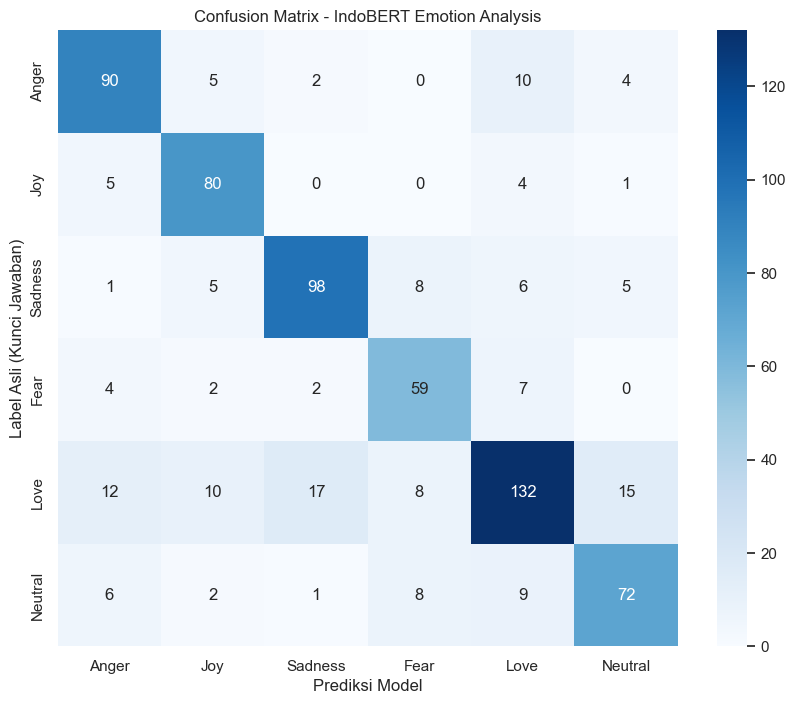

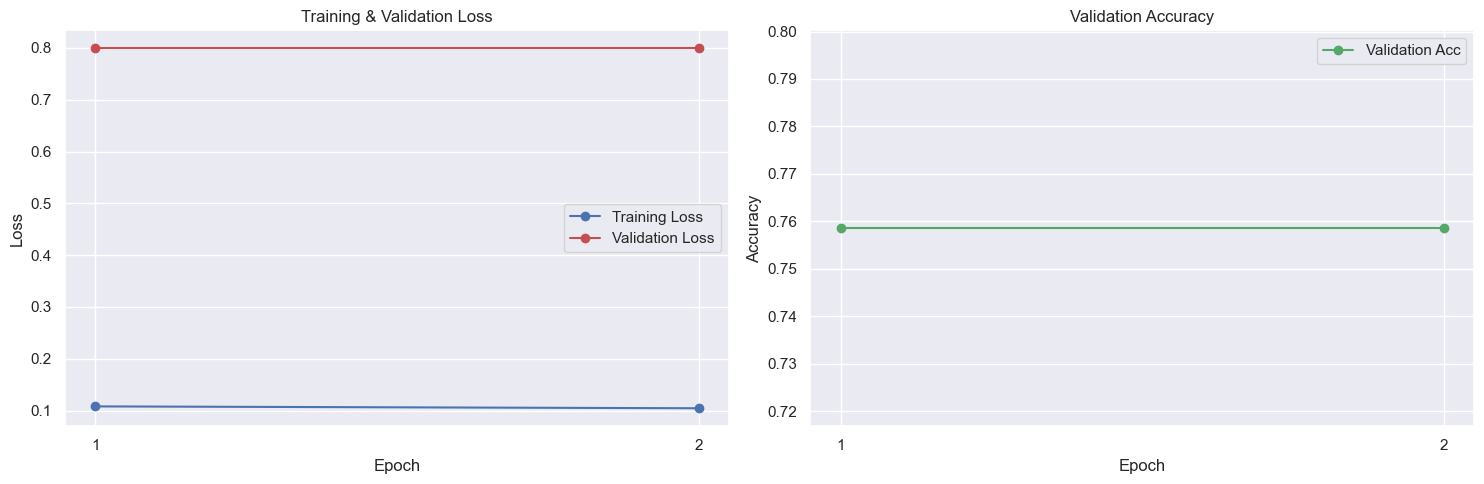

In [23]:
print("📝 Memulai Evaluasi pada Data Test...")

# 1. Prediksi Data Test
model.eval() # Mode Evaluasi

predictions = []
true_labels = []

# Loop prediksi (sama kayak validasi tapi untuk data test)
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Ambil index dengan nilai tertinggi sebagai prediksi
    pred_flat = np.argmax(logits, axis=1).flatten()
    
    predictions.extend(pred_flat)
    true_labels.extend(label_ids)

print("✅ Prediksi Selesai!")

# 2. Definisikan Label (Agar laporan bisa dibaca)
# Sesuaikan urutan ini dengan label_map di Notebook 01
target_names = ['Anger', 'Joy', 'Sadness', 'Fear', 'Love', 'Neutral'] 

# 3. Tampilkan Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, predictions, target_names=target_names, digits=4))

# 4. Visualisasi Confusion Matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Label Asli (Kunci Jawaban)')
plt.xlabel('Prediksi Model')
plt.title('Confusion Matrix - IndoBERT Emotion Analysis')
plt.show()

# Ubah data history menjadi DataFrame biar enak diolah
df_stats = pd.DataFrame(data=training_stats)

# Gunakan style seaborn biar grafik lebih modern
sns.set(style='darkgrid')

# Buat canvas gambar (kiri buat Loss, kanan buat Accuracy)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- GRAFIK 1: LOSS (Error) ---
axes[0].plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label='Training Loss')
axes[0].plot(df_stats['epoch'], df_stats['Valid. Loss'], 'r-o', label='Validation Loss')
axes[0].set_title("Training & Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_xticks(df_stats['epoch']) # Pastikan sumbu X bilangan bulat (Epoch 1, 2, 3...)

# --- GRAFIK 2: ACCURACY (Akurasi) ---
# Note: Training Accuracy tidak kita hitung di loop tadi (biar cepat), jadi cuma Val Accuracy
axes[1].plot(df_stats['epoch'], df_stats['Valid. Accur.'], 'g-o', label='Validation Acc')
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_xticks(df_stats['epoch'])

plt.tight_layout()
plt.show()

## **8. Hyper Tuning**

In [ ]:
# --- DAFTAR KANDIDAT SKENARIO ---
scenarios = [
    # Skenario 1: Baseline (Standar)
    {"name": "A (Baseline)", "lr": 2e-5, "dropout": 0.1, "decay": 0.0, "grad_acc": 1},
    
    # Skenario 2: Balanced (Sedikit lebih ketat)
    {"name": "B (Balanced)", "lr": 3e-5, "dropout": 0.2, "decay": 0.01, "grad_acc": 2},
    
    # Skenario 3: Anti-Overfit (Sangat ketat & Stabil)
    {"name": "C (Anti-Overfit)", "lr": 2e-5, "dropout": 0.3, "decay": 0.02, "grad_acc": 4}
]

EPOCHS_TUNE = 2 # Cukup 2 Epoch per skenario untuk intip performa
best_val_acc = 0
best_scenario = None

print(f"🚀 MEMULAI ULTIMATE TUNING ({len(scenarios)} Skenario)...")
print("Tujuan: Mencari obat anti-overfitting terbaik.")

for sc in scenarios:
    print(f"\n==================================================")
    print(f"🧪 Testing Skenario: {sc['name']}")
    print(f"   ► LR: {sc['lr']} | Dropout: {sc['dropout']} | Decay: {sc['decay']} | Grad Acc: {sc['grad_acc']}")
    print(f"==================================================")

    # 1. BERSIH-BERSIH MEMORI (PENTING BANGET BUAT GTX 1650)
    if 'model' in globals(): del model
    if 'optimizer' in globals(): del optimizer
    torch.cuda.empty_cache()
    gc.collect()

    # 2. SETUP CONFIG MODEL (Atur Dropout di sini)
    config = BertConfig.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=6,
        hidden_dropout_prob=sc['dropout'],          # Dropout Layer Utama
        attention_probs_dropout_prob=sc['dropout']  # Dropout di Attention
    )

    # 3. LOAD MODEL
    model = BertForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        config=config
    )
    model.to(device)

    # 4. OPTIMIZER (Atur Weight Decay di sini)
    optimizer = AdamW(model.parameters(), lr=sc['lr'], weight_decay=sc['decay'], eps=1e-8)

    # 5. SCHEDULER
    # Total steps = (Jumlah Batch / Grad Accumulation) * Epochs
    steps_per_epoch = len(train_dataloader) // sc['grad_acc']
    total_steps = steps_per_epoch * EPOCHS_TUNE
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # --- TRAINING LOOP (Dengan Gradient Accumulation) ---
    for epoch in range(EPOCHS_TUNE):
        model.train()
        total_loss = 0
        optimizer.zero_grad() # Reset grad di awal epoch

        # Pakai tqdm biar kelihatan jalan
        train_iterator = tqdm(train_dataloader, desc=f"Ep {epoch+1} Train", leave=False)

        for step, batch in enumerate(train_iterator):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            # Hitung Loss (Pakai Class Weights yg sudah kita buat sebelumnya)
            loss = loss_fct(outputs.logits, b_labels)
            
            # BAGI LOSS DENGAN ACCUMULATION STEPS
            loss = loss / sc['grad_acc']
            loss.backward() # Simpan gradient (jangan di-step dulu)

            # Jika sudah mengumpulkan cukup gradient ATAU ini batch terakhir
            if (step + 1) % sc['grad_acc'] == 0 or (step + 1) == len(train_dataloader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()    # Update bobot
                scheduler.step()    # Update LR
                model.zero_grad()   # Bersihkan gradient
            
            total_loss += loss.item()

        # --- VALIDATION LOOP ---
        model.eval()
        total_eval_acc = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            loss = loss_fct(outputs.logits, b_labels)
            total_eval_loss += loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_acc += flat_accuracy(logits, label_ids)

        avg_val_acc = total_eval_acc / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        print(f"   Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f} | Val Acc = {avg_val_acc:.4f}")

    # Cek Rekor
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        best_scenario = sc
        print(f"   🌟 Kandidat Kuat! Akurasi: {best_val_acc:.4f}")

print("\n==================================================")
print("✅ EXPERIMENT SELESAI!")
print(f"👑 Skenario Terbaik: {best_scenario['name']}")
print(f"📊 Akurasi: {best_val_acc:.4f}")
print("Gunakan parameter dari skenario ini untuk Training Final di Bagian 7.")